In [36]:
from io import BytesIO
from zipfile import ZipFile, BadZipFile
import requests
from datetime import date, datetime
from pathlib import Path
import pandas as pd
import json
import re
from pprint import pprint
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt

In [37]:
plt.style.use('fivethirtyeight')
data_path = Path('data')

In [38]:
data_path

PosixPath('data')

In [43]:
(data_path / '2018' / 'source' / 'file.parquet').parents[1]

PosixPath('data/2018')

### Dowload FS & Notes

In [3]:
SEC_URL = 'https://www.sec.gov/files/dera/data/financial-statement-and-notes-data-sets/'

today = pd.Timestamp(date.today())
this_year = today.year
this_quarter = today.quarter

past_years = range(2014, this_year)
filing_periods = [(y, q) for y in past_years for q in range(1, 5)]
filing_periods.extend([(this_year, q) for q in range(1, this_quarter + 1)])
for i, (yr, qtr) in enumerate(filing_periods, 1):
    print(yr, qtr, end=' ', )
    filing = f'{yr}q{qtr}_notes.zip'
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(exist_ok=True, parents=True)

    resp = requests.get(SEC_URL + filing).content
    
    try:
        with ZipFile(BytesIO(resp)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        continue

2014 1
2014 2
2014 3
2014 4
2015 1
2015 2
2015 3
2015 4
2016 1
2016 2
2016 3
2016 4
2017 1
2017 2
2017 3
2017 4
2018 1
2018 2
2018 3
2018 4


BadZipFile: File is not a zip file

### Save to parquet

In [8]:
for f in data_path.glob('**/*.tsv'):
    file_name = f.stem  + '.parquet'
    path = Path(f.parent) / 'parquet'
    if (path / file_name).exists():
        continue
    if not path.exists():
        path.mkdir(exist_ok=True)
    try:
        df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False)
    except:
        print(f)
    df.to_parquet(path / file_name)

edgar/2017_1/tag.tsv
edgar/2015_4/txt.tsv
edgar/2016_1/txt.tsv
edgar/2015_3/txt.tsv
edgar/2017_2/tag.tsv
edgar/2015_1/txt.tsv
edgar/2016_3/tag.tsv
edgar/2017_4/tag.tsv
edgar/2014_4/txt.tsv
edgar/2014_1/txt.tsv
edgar/2014_2/txt.tsv
edgar/2015_2/txt.tsv
edgar/2014_3/txt.tsv


### Metadata json

In [13]:
file = edgar_path / '2018_3' / '2018q1_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

FileNotFoundError: [Errno 2] No such file or directory: 'edgar/2018_3/2018q1_notes-metadata.json'

### Submission Data
Get latest submission file

In [15]:
sub = pd.read_parquet(edgar_path / '2018_3' / 'parquet' / 'sub.parquet')

#### Get AAPL submission

In [16]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

name                    APPLE INC
adsh         0000320193-18-000100
cik                        320193
name                    APPLE INC
sic                          3571
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1           ONE APPLE PARK WAY
form                         10-Q
period                   20180630
fy                           2018
fp                             Q3
filed                    20180801
Name: 386, dtype: object

### Build AAPL fundamentals dataset

#### Get filings

In [20]:
aapl_subs = pd.DataFrame()
for sub in edgar_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

In [22]:
aapl_subs.form.value_counts()

10-Q    15
10-K     4
Name: form, dtype: int64

#### Get numerical filing data

In [23]:
aapl_nums = pd.DataFrame()
for num in edgar_path.glob('**/num.parquet'):
    num = pd.read_parquet(num)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])

aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')    
aapl_nums.to_parquet('aapl_nums.parquet')
aapl_nums.info()

738
1345
707
961
1001
905
951
1277
937
751
923
793
1364
1271
682
805
942
919
952
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18224 entries, 84837 to 5467444
Data columns (total 16 columns):
adsh        18224 non-null object
tag         18224 non-null object
version     18224 non-null object
ddate       18224 non-null datetime64[ns]
qtrs        18224 non-null int64
uom         18224 non-null object
dimh        18224 non-null object
iprx        18224 non-null float64
value       18176 non-null float64
footnote    68 non-null object
footlen     18224 non-null int64
dimn        18224 non-null int64
coreg       0 non-null object
durp        18224 non-null float64
datp        18224 non-null float64
dcml        18224 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(7)
memory usage: 2.4+ MB


In [24]:
aapl_nums = pd.read_parquet('aapl_nums.parquet')
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18224 entries, 84837 to 5467444
Data columns (total 16 columns):
adsh        18224 non-null object
tag         18224 non-null object
version     18224 non-null object
ddate       18224 non-null datetime64[ns]
qtrs        18224 non-null int64
uom         18224 non-null object
dimh        18224 non-null object
iprx        18224 non-null float64
value       18176 non-null float64
footnote    68 non-null object
footlen     18224 non-null int64
dimn        18224 non-null int64
coreg       0 non-null object
durp        18224 non-null float64
datp        18224 non-null float64
dcml        18224 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(7)
memory usage: 2.4+ MB


#### Build time series for selected metrics

In [26]:
stock_split = 7
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

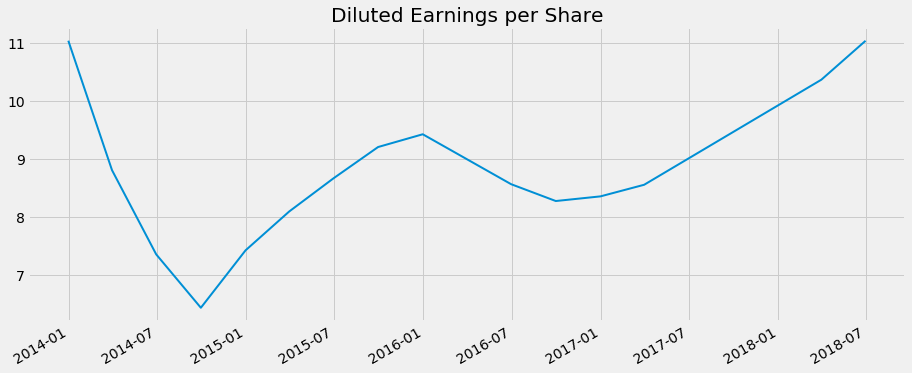

In [27]:
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze()
eps = eps.rolling(4).sum().dropna()
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('');

In [28]:
import pandas_datareader.data as web
import datetime
symbol = 'AAPL.US'

aapl_stock = web.DataReader(symbol, 'quandl', '2009-06-01').resample('D').last()
aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3222 entries, 2009-06-01 to 2018-03-27
Freq: D
Data columns (total 12 columns):
Open          2220 non-null float64
High          2220 non-null float64
Low           2220 non-null float64
Close         2220 non-null float64
Volume        2220 non-null float64
ExDividend    2220 non-null float64
SplitRatio    2220 non-null float64
AdjOpen       2220 non-null float64
AdjHigh       2220 non-null float64
AdjLow        2220 non-null float64
AdjClose      2220 non-null float64
AdjVolume     2220 non-null float64
dtypes: float64(12)
memory usage: 327.2 KB


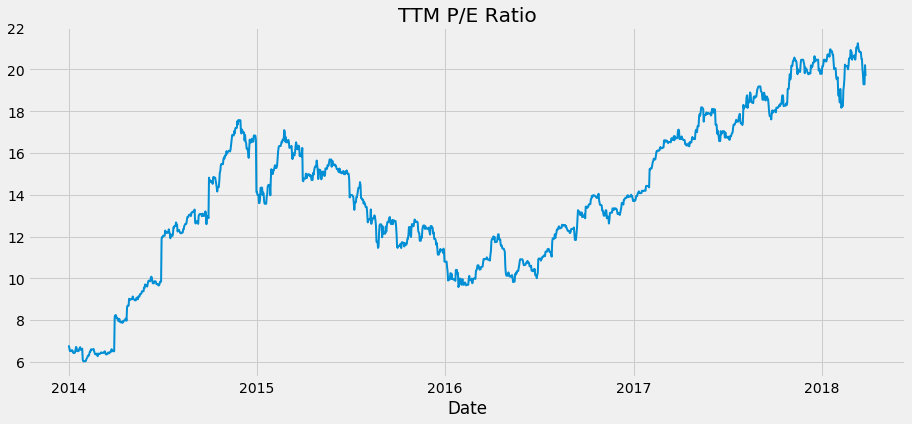

In [29]:
pe = aapl_stock.AdjClose.to_frame('price').join(eps.to_frame('eps'))
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [30]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

In [32]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18224 entries, 84837 to 5467444
Data columns (total 16 columns):
adsh        18224 non-null object
tag         18224 non-null object
version     18224 non-null object
ddate       18224 non-null datetime64[ns]
qtrs        18224 non-null int64
uom         18224 non-null object
dimh        18224 non-null object
iprx        18224 non-null float64
value       18176 non-null float64
footnote    68 non-null object
footlen     18224 non-null int64
dimn        18224 non-null int64
coreg       0 non-null object
durp        18224 non-null float64
datp        18224 non-null float64
dcml        18224 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(7)
memory usage: 3.0+ MB


In [31]:
aapl_nums.loc[fields].dropna(how='all', axis=1)

KeyError: "None of [['EarningsPerShareDiluted', 'PaymentsOfDividendsCommonStock', 'WeightedAverageNumberOfDilutedSharesOutstanding', 'OperatingIncomeLoss', 'NetIncomeLoss', 'GrossProfit']] are in the [index]"

In [30]:
metrics = aapl_nums.loc[fields].dropna(how='all', axis=1).T

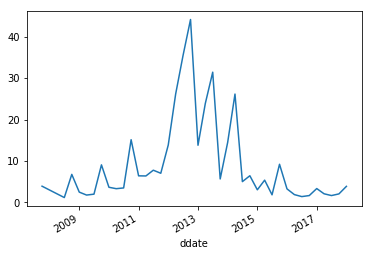

In [26]:
%matplotlib inline
aapl_nums.loc[fields].dropna(how='all', axis=1).T.EarningsPerShareDiluted.plot();

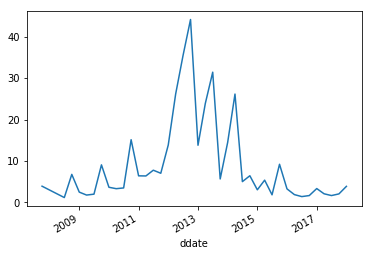

In [72]:
metrics.EarningsPerShareDiluted.plot();

### Bonus: Textual Information

In [35]:
txt = pd.read_parquet(edgar_path / '2018_3' / 'parquet' /  'txt.parquet')
apple_txt = txt[txt.adsh == apple_10Q.adsh]

NameError: name 'apple_10Q' is not defined

In [155]:
apple_txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 385906 to 472369
Data columns (total 20 columns):
adsh        91 non-null object
tag         91 non-null object
version     91 non-null object
ddate       91 non-null int64
qtrs        91 non-null int64
iprx        91 non-null int64
lang        91 non-null object
dcml        91 non-null int64
durp        91 non-null float64
datp        91 non-null float64
dimh        91 non-null object
dimn        91 non-null int64
coreg       0 non-null object
escaped     91 non-null int64
srclen      91 non-null int64
txtlen      91 non-null int64
footnote    0 non-null object
footlen     91 non-null int64
context     91 non-null object
value       91 non-null object
dtypes: float64(2), int64(9), object(9)
memory usage: 14.9+ KB


In [158]:
apple_txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
385906,0000320193-18-000007,IntangibleAssetsDisclosureTextBlock,us-gaap/2017,20171231,1,0,en-US,32767,0.013699,1.0,0x00000000,0,None,1,25110,737,None,0,FD2018Q1YTD,Acquired Intangible Assets The Companys acquir...
385907,0000320193-18-000007,SegmentReportingPolicyPolicyTextBlock,us-gaap/2017,20171231,1,0,en-US,32767,0.013699,1.0,0x00000000,0,None,1,2987,2307,None,0,FD2018Q1YTD,The Company reports segment information based ...
390115,0000320193-18-000007,LongTermMarketableSecuritiesMaturitiesTermMaximum,0000320193-18-000007,20171231,1,0,en-US,32767,0.013699,1.0,0x00000000,0,None,0,3,3,None,0,FD2018Q1YTD,P5Y
390116,0000320193-18-000007,ShareBasedCompensationArrangementByShareBasedP...,us-gaap/2017,20171231,1,0,en-US,32767,0.013699,1.0,0x0ab20a3d6dd2f89ce1deb1da25a80ac0,1,None,0,3,3,None,0,FD2018Q1QTD_us-gaap_AwardTypeAxis_us-gaap_Rest...,P4Y
393030,0000320193-18-000007,TradingSymbol,dei/2014,20171231,1,0,en-US,32767,0.013699,1.0,0x00000000,0,None,0,4,4,None,0,FD2018Q1YTD,AAPL


In [159]:
tags = pd.read_parquet(notes_dir / 'parquet' / 'tag.parquet')
tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876087 entries, 0 to 876086
Data columns (total 9 columns):
tag         876085 non-null object
version     876087 non-null object
custom      876087 non-null int64
abstract    876087 non-null int64
datatype    821031 non-null object
iord        509567 non-null object
crdr        250009 non-null object
tlabel      875600 non-null object
doc         810912 non-null object
dtypes: int64(2), object(7)
memory usage: 66.8+ MB


In [160]:
tags.head()

,tag,version,custom,abstract,datatype,iord,crdr,tlabel,doc
0,EntityDomain,dei/2014,0,1,member,None,None,Entity [Domain],All the names of the entities being reported u...
1,LegalEntityAxis,dei/2014,0,1,axis,None,None,Legal Entity [Axis],The set of legal entities associated with a re...
2,EntityPublicFloat,dei/2014,0,0,monetary,I,C,Entity Public Float,State aggregate market value of voting and non...
3,DocumentFiscalYearFocus,dei/2014,0,0,gYear,D,None,Document Fiscal Year Focus,This is focus fiscal year of the document repo...
4,DocumentPeriodEndDate,dei/2014,0,0,date,D,None,Document Period End Date,The end date of the period reflected on the co...


In [161]:
apple_txt.merge(tags, how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 90
Data columns (total 27 columns):
adsh        91 non-null object
tag         91 non-null object
version     91 non-null object
ddate       91 non-null int64
qtrs        91 non-null int64
iprx        91 non-null int64
lang        91 non-null object
dcml        91 non-null int64
durp        91 non-null float64
datp        91 non-null float64
dimh        91 non-null object
dimn        91 non-null int64
coreg       0 non-null object
escaped     91 non-null int64
srclen      91 non-null int64
txtlen      91 non-null int64
footnote    0 non-null object
footlen     91 non-null int64
context     91 non-null object
value       91 non-null object
custom      91 non-null int64
abstract    91 non-null int64
datatype    91 non-null object
iord        91 non-null object
crdr        0 non-null object
tlabel      91 non-null object
doc         91 non-null object
dtypes: float64(2), int64(11), object(14)
memory usage: 19.9+ KB


Unfortunately this gets truncated. Back to XBRL source..

In [156]:
apple_txt.sort_values('txtlen', ascending=False).loc[:, ['srclen', 'txtlen', 'tag', 'value']].head(20)

,srclen,txtlen,tag,value
415690,334107,17551,FinancialInstrumentsDisclosureTextBlock,"Financial Instruments Cash, Cash Equivalents a..."
426357,23610,8928,CommitmentsAndContingenciesDisclosureTextBlock,Commitments and Contingencies Accrued Warranty...
443171,28291,6271,BasisOfPresentationAndSignificantAccountingPol...,Summary of Significant Accounting Policies App...
393031,9142,5596,DerivativesPolicyTextBlock,The Company records all derivatives in the Con...
472369,203569,5191,DebtDisclosureTextBlock,Debt Commercial Paper The Company issues unsec...
411033,9637,4891,IncomeTaxDisclosureTextBlock,"Income Taxes On December 22, 2017, the U.S. en..."
411035,68777,4020,StockholdersEquityNoteDisclosureTextBlock,Shareholders Equity Dividends The Company decl...
393032,45318,3357,SegmentReportingDisclosureTextBlock,Segment Information and Geographic Data The Co...
402283,31926,2771,CompensationAndEmployeeBenefitPlansTextBlock,Benefit Plans Stock Plans The Company had 273....
430946,209183,2661,CashCashEquivalentsandAvailableforSaleSecuriti...,The following tables show the Companys cash an...


In [65]:
apple_txt.to_csv('apple_file.csv', index=False)

#### Get index

In [57]:
index_path = data_path / 'filings'

In [58]:
index = pd.read_parquet(index_path / 'index.parquet')
index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17679083 entries, 0 to 952928
Data columns (total 5 columns):
cik        object
company    object
form       object
date       datetime64[ns]
url        object
dtypes: datetime64[ns](1), object(4)
memory usage: 809.3+ MB


In [59]:
filing = index[(index.cik.astype(int) == apple_10Q.cik) & 
            (index.form == apple_sub.form) & 
            (index.date.dt.year == 2018) &
            (index.date.dt.quarter == 1)
           ]
filing.url

236420    edgar/data/320193/0000320193-18-000007.txt
Name: url, dtype: object

In [113]:
apple_sub.adsh

'0000320193-18-000007'

In [150]:
xbrl_tag = 'us-gaap:FinancialInstrumentsDisclosureTextBlock'

In [153]:
url = f'https://www.sec.gov/Archives/edgar/data/{apple_sub.cik}/{apple_sub.adsh}.txt'
f = requests.get(url=url).text

In [163]:
s = re.search(r'{0}(.*?){0}'.format(xbrl_tag), f)
print(len(s.group(1)))

388906


In [157]:
soup = BeautifulSoup(f, 'lxml')
for tag in soup.find_all():
    if tag.name in apple_txt.tag.tolist():
        print(tag, ': ' + tag.text)

In [165]:
res = re.search(xbrl_tag, f)

In [167]:
f[start-50: stop+150]

'rValueMeasurementPolicyPolicyTextBlock>\n\t<us-gaap:FinancialInstrumentsDisclosureTextBlock contextRef="FD2018Q1YTD" id="Fact-D561C3C1DC2A5F31BF6C478E622A44CF">&lt;div style="font-family:Times New Roman;font-size:10pt;"&gt;&lt;div style="lin'